### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 7
### Due: Saturday, Apr 10th at 11.59pm CST
---

## Only one problem this week

This is a regression problem. Note of warning: the data I have provided have associated uncertainties, `yerr`. `sklearn` and `astroML` have different formats for using uncertainties; in `sklearn` fitting you can provide `sample_weight=1/yerr**2`, while in `astroML` fitting you can directly provide `y_error=yerr`.

1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.


2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

In [ ]:
# Makes the plot interactive. 
# You can pan the image.
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(___, ___, y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(___.flatten(), ___.flatten(), ___, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

In [ ]:
# To turn off interactive plotting
%matplotlib inline

4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*


5. Perform Nadaraya-Watson regression on the data, using a Gaussian kernel with a bandwidth of $0.2$. Visualize interactively as before. How does this look compared to previous models?


6. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


7. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


8. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out a $20\%$ cross-validation set from the training set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

In [1]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt

from astroML.linear_model import LinearRegression, NadarayaWatson, PolynomialRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor

from IPython.display import display, Math, Latex

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


##### 1.

In [2]:
# load in the data
data = np.load('../../homeworks/hw_data/hw7_data_1.npy')

In [3]:
X = data[:,:2]
y = data[:,2]
yerr = data[:,3]

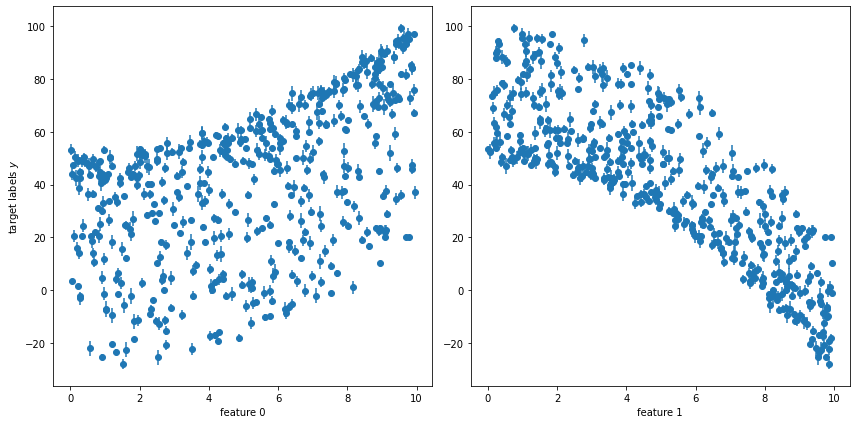

In [4]:
# plotting the datapoints
fig, axs = plt.subplots(ncols=2, figsize=(12,6),
                        tight_layout=True, sharex=True)

ax = axs[0]
ax.errorbar(X[:,0], y, yerr, fmt='o')
ax.set_xlabel('feature 0')
ax.set_ylabel(r'target labels $y$')

ax = axs[1]
ax.errorbar(X[:,1], y, yerr, fmt='o')
ax.set_xlabel('feature 1');

##### 2. 

In [5]:
# linear regression
lr = LinearRegression()
lr.fit(X, y, yerr)

theta0, theta1, theta2 = lr.coef_

Calculated coefficients $\theta_0$, $\theta_1$, $\theta_2$:

In [6]:
print(theta0, theta1, theta2)

57.10102323299546 4.948730161178386 -8.300234070064484


In [7]:
# creating grid of points along both features
u = np.linspace(X[:,0].min(), X[:,0].max(), 50)
v = np.linspace(X[:,1].min(), X[:,1].max(), 50)

# prediciting labels for each feature along slice
# corresponding to mean of other feature
y_pred0 = theta0 + theta1*u + theta2*np.mean(v)
y_pred1 = theta0 + theta1*np.mean(u) + theta2*v

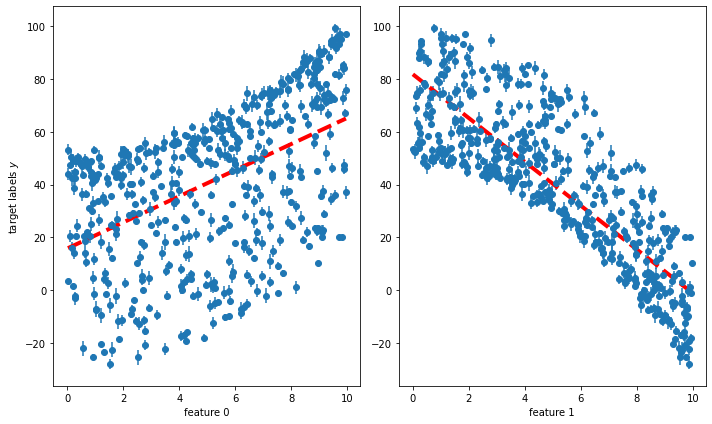

In [8]:
# overplot predicted y
fig, axs = plt.subplots(ncols=2, figsize=(10,6),
                        tight_layout=True, sharex=True)

ax = axs[0]
ax.errorbar(X[:,0], y, yerr, fmt='o')
ax.plot(u, y_pred0, 'r--', linewidth=4)
ax.set_xlabel('feature 0')
ax.set_ylabel(r'target labels $y$')

ax = axs[1]
ax.errorbar(X[:,1], y, yerr, fmt='o')
ax.plot(v, y_pred1, 'r--', linewidth=4)
ax.set_xlabel('feature 1');

The prediction is within the dataset spread, but it doesn't model the curvature at all

##### 3.

In [9]:
# creating a meshgrid of points within features range
u = np.linspace(X[:,0].min(), X[:,0].max(), 50)
v = np.linspace(X[:,1].min(), X[:,1].max(), 50)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T

# predicitng using meshgrid of points
y_pred2 = lr.predict(Xgrid)

<ipython-input-9-51972e429e24>:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T


<IPython.core.display.Javascript object>


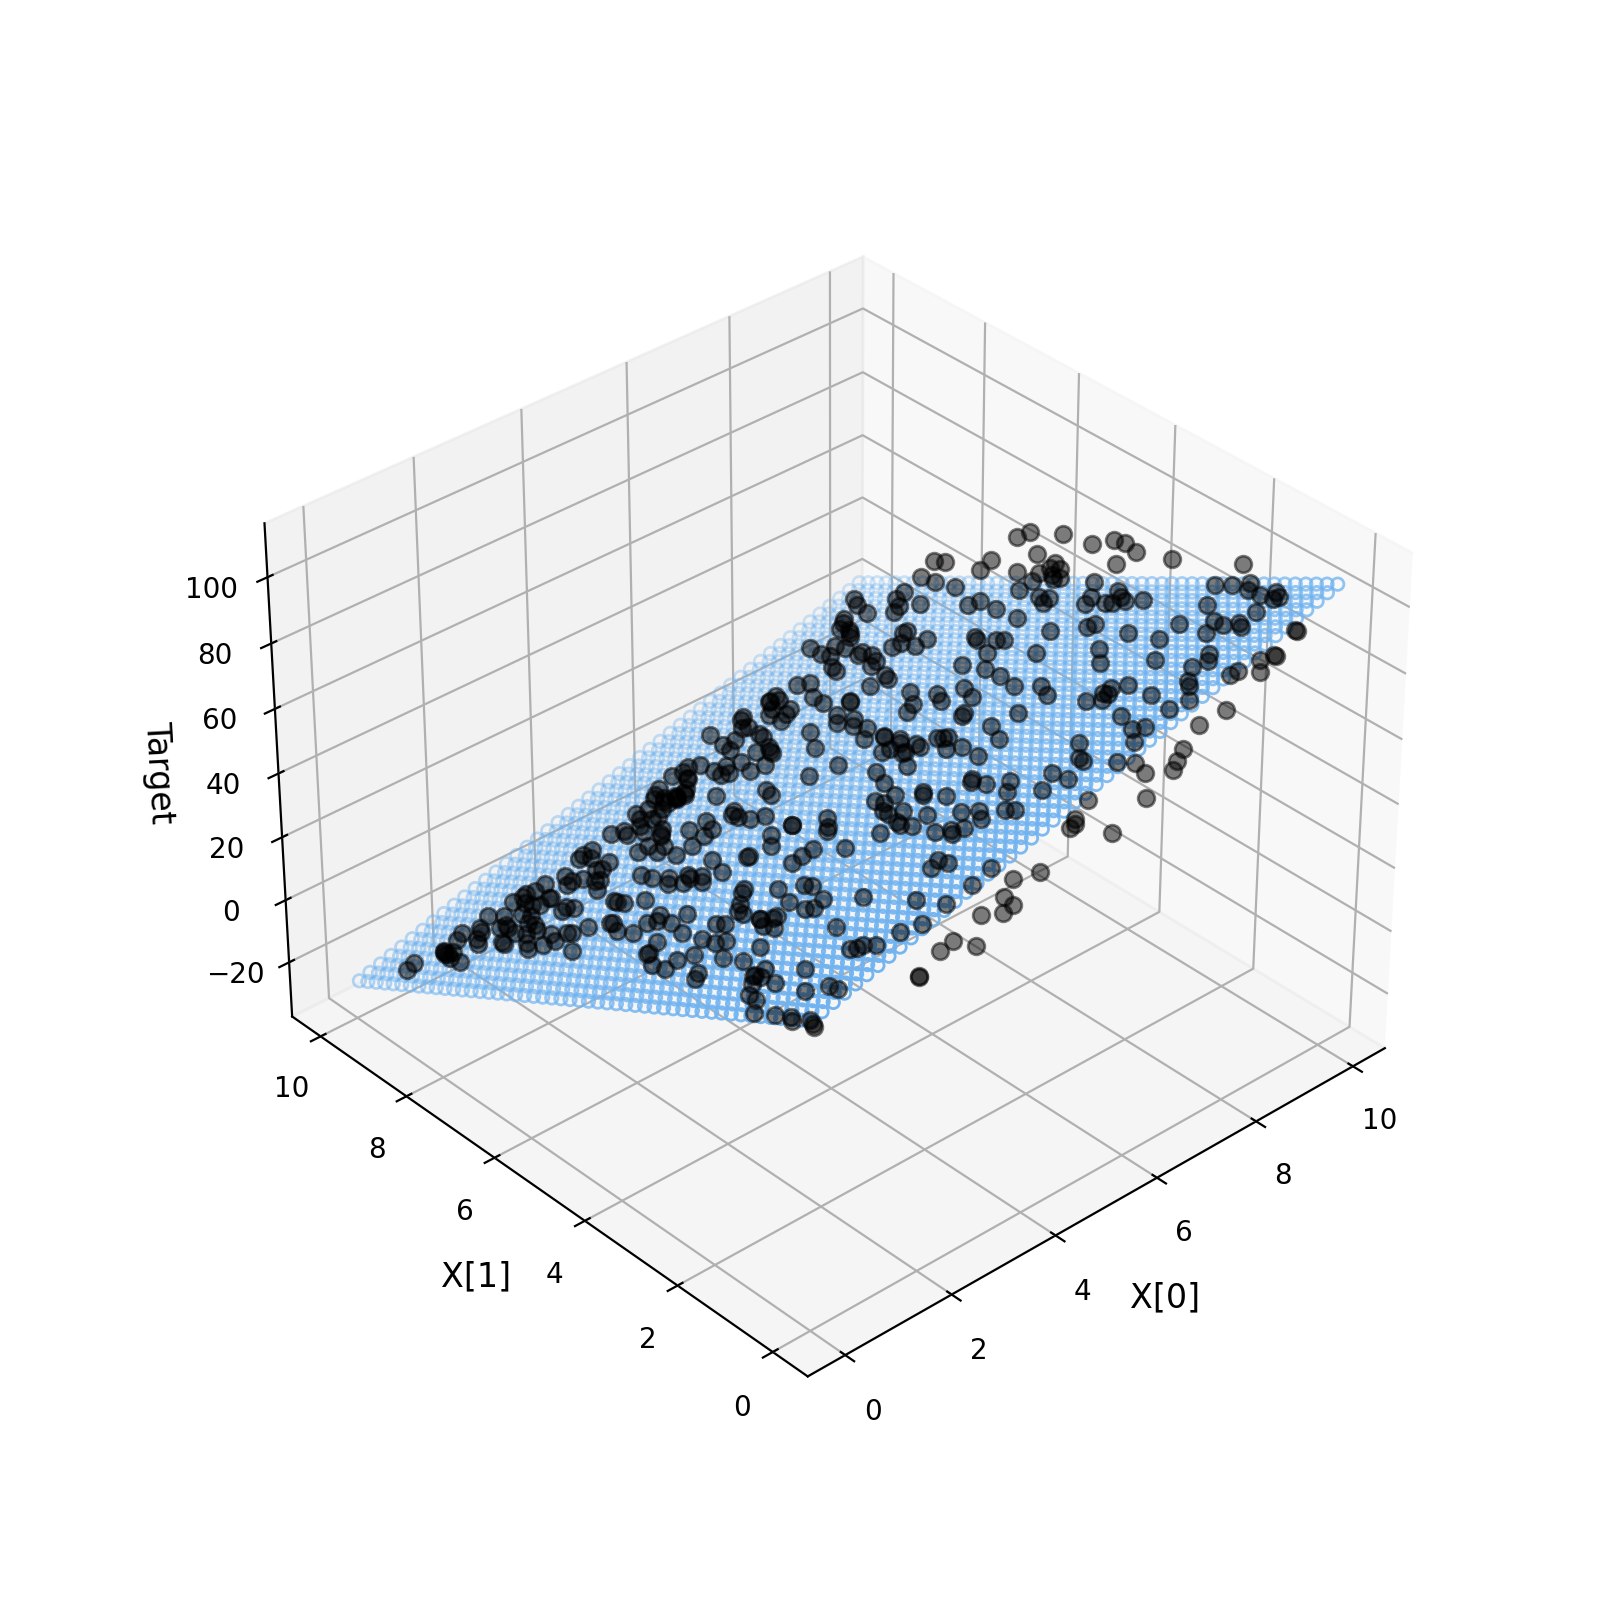

In [10]:
# plot interactive plot
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0], X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0].flatten(), Xgrid[:,1].flatten(), y_pred2, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

In [11]:
# To turn off interactive plotting
%matplotlib inline

##### 4.

In [19]:
# using gridsearchcv to find best parameters for ridge
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0],
                'solver': ['svd', 'lsqr']}
cv = GridSearchCV(Ridge(), ridge_params) # default = 5-fold cv
cv.fit(X, y, sample_weight=1/yerr**2)

a_opt = cv.best_params_

In [22]:
print('Best parameters:')
print(a_opt)

print('\nBest score:')
print(cv.best_score_)

Best parameters:
{'alpha': 1.0, 'solver': 'lsqr'}

Best score:
0.929182742615996


In [23]:
# model predict with best values
ridge = Ridge(alpha=a_opt['alpha'], solver=a_opt['solver'])
ridge.fit(X, y, 1/yerr**2)
y_pred_R = ridge.predict(Xgrid)

<IPython.core.display.Javascript object>


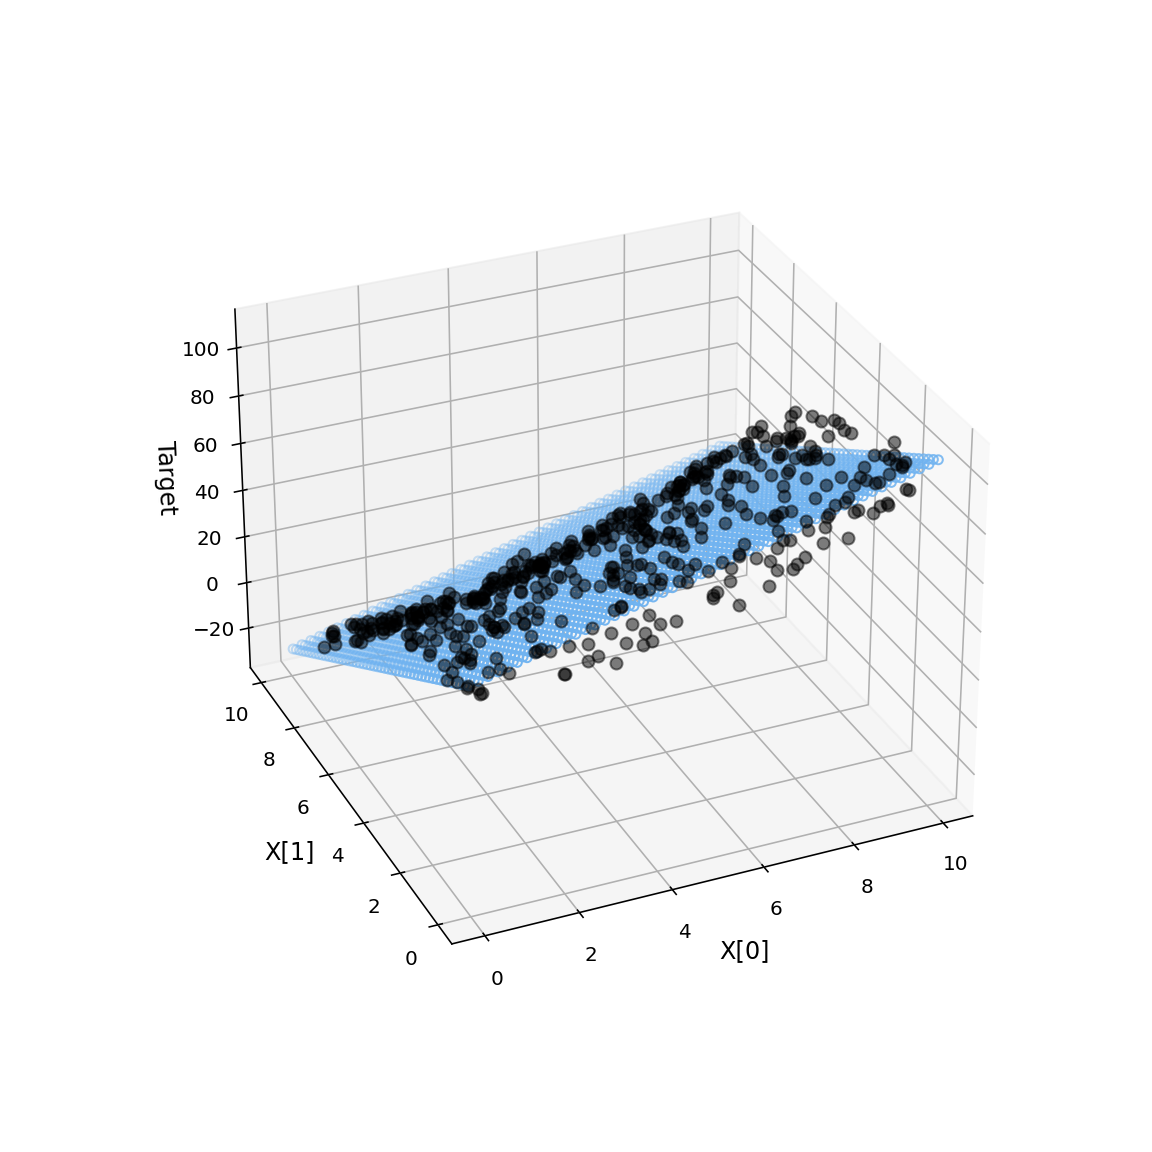

In [24]:
# plot interative plot of ridge
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0], X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0].flatten(), Xgrid[:,1].flatten(), y_pred_R, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

In [25]:
# To turn off interactive plotting
%matplotlib inline

In [27]:
# using RidgeCV
Rcv = RidgeCV(ridge_params['alpha'])
Rcv.fit(X, y, 1/yerr**2)
y_pred_Rcv = Rcv.predict(Xgrid)

print(f'Best alpha = {Rcv.alpha_}')
print('This is the same as was found using GridSearchCV')

Best alpha = 1.0


<IPython.core.display.Javascript object>


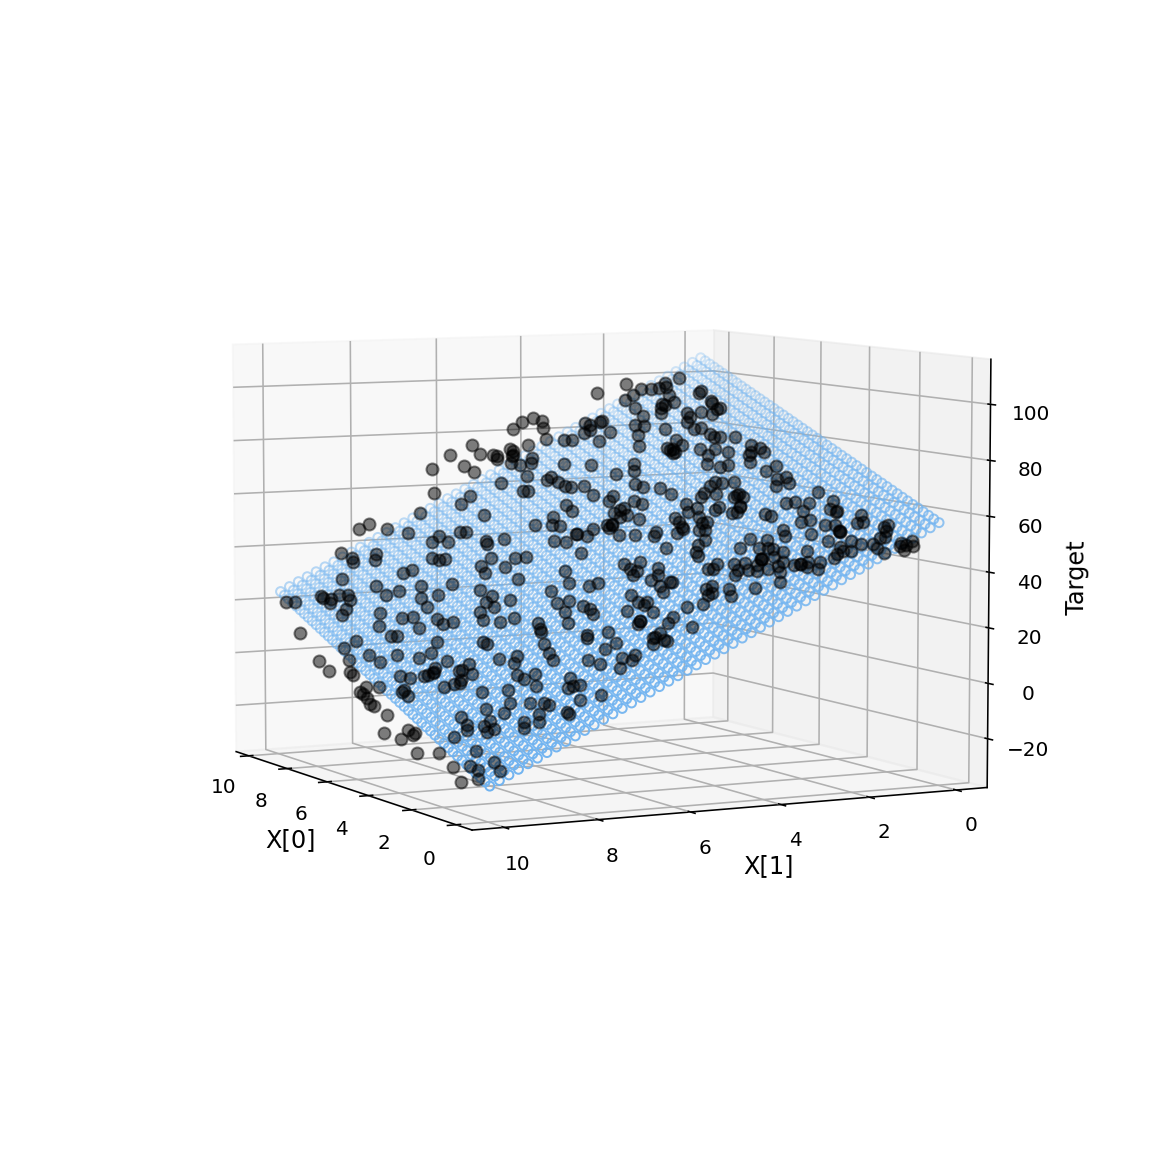

In [28]:
# yet another interactive plot
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0], X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0].flatten(), Xgrid[:,1].flatten(), y_pred_Rcv, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

In [29]:
# To turn off interactive plotting
%matplotlib inline

##### 5.

In [30]:
# performing nadaraya-watson kernel regression
nw = NadarayaWatson(h=0.2)
nw.fit(X, y, yerr)
y_pred_nw = nw.predict(Xgrid)

<IPython.core.display.Javascript object>


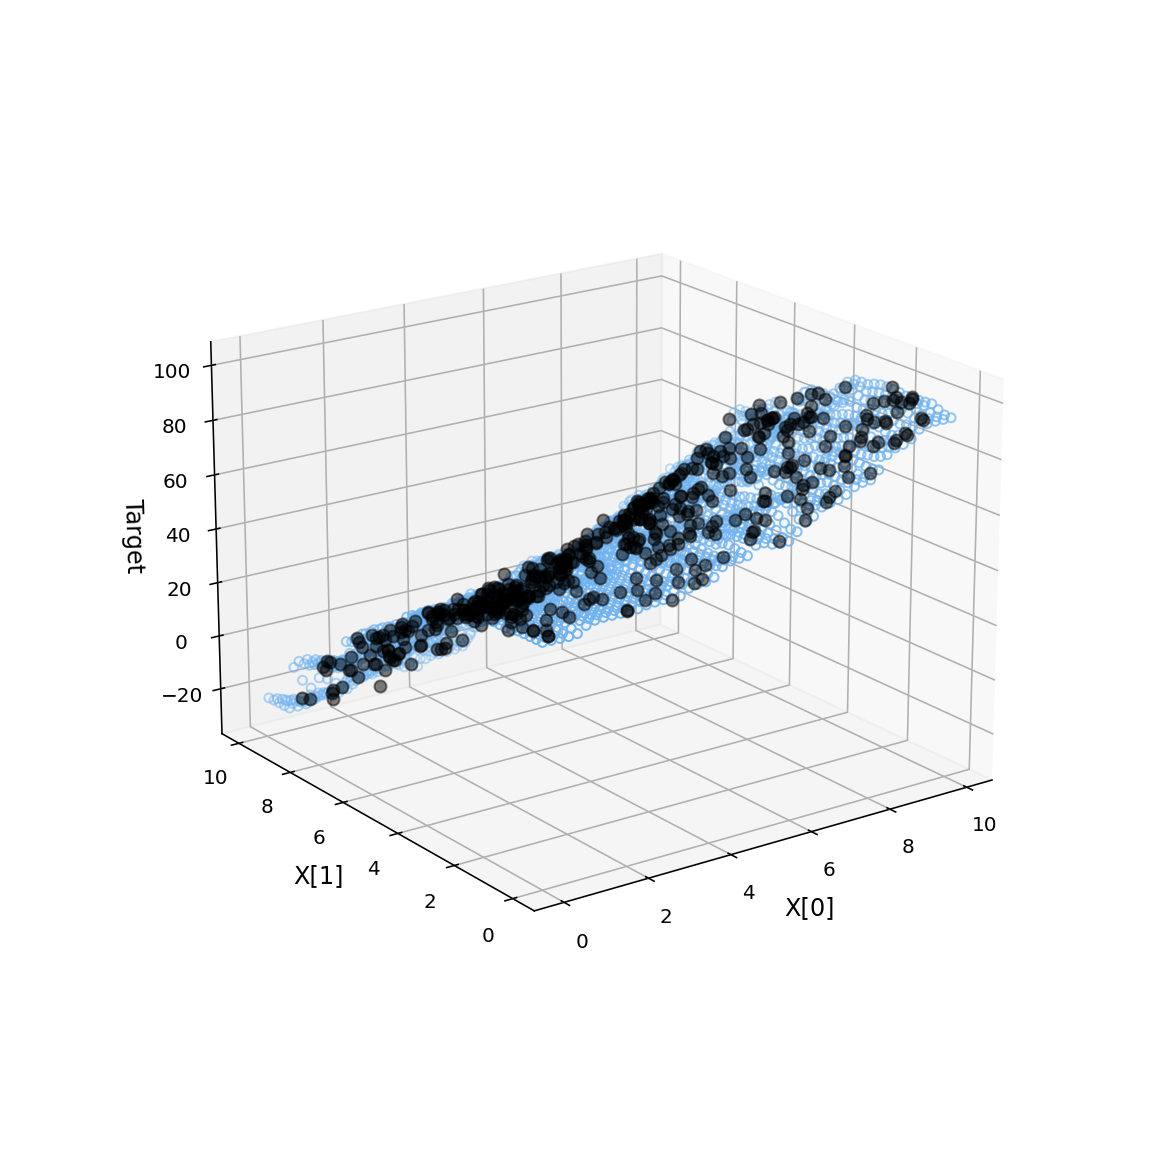

In [31]:
# playful plots...
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0], X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0].flatten(), Xgrid[:,1].flatten(), y_pred_nw, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

In [32]:
# To turn off interactive plotting
%matplotlib inline

This model is the best so far as it follows the contour of the dataset, rather than be a flat plane

##### 6.

In [35]:
# performing a GPR
# without errors
gp1 = GaussianProcessRegressor()
gp1.fit(X, y)
y_pred_gp1 = gp1.predict(Xgrid)

# with errors
gp2 = GaussianProcessRegressor(alpha=(yerr/y)**2)
gp2.fit(X, y)
y_pred_gp2 = gp2.predict(Xgrid)

<IPython.core.display.Javascript object>


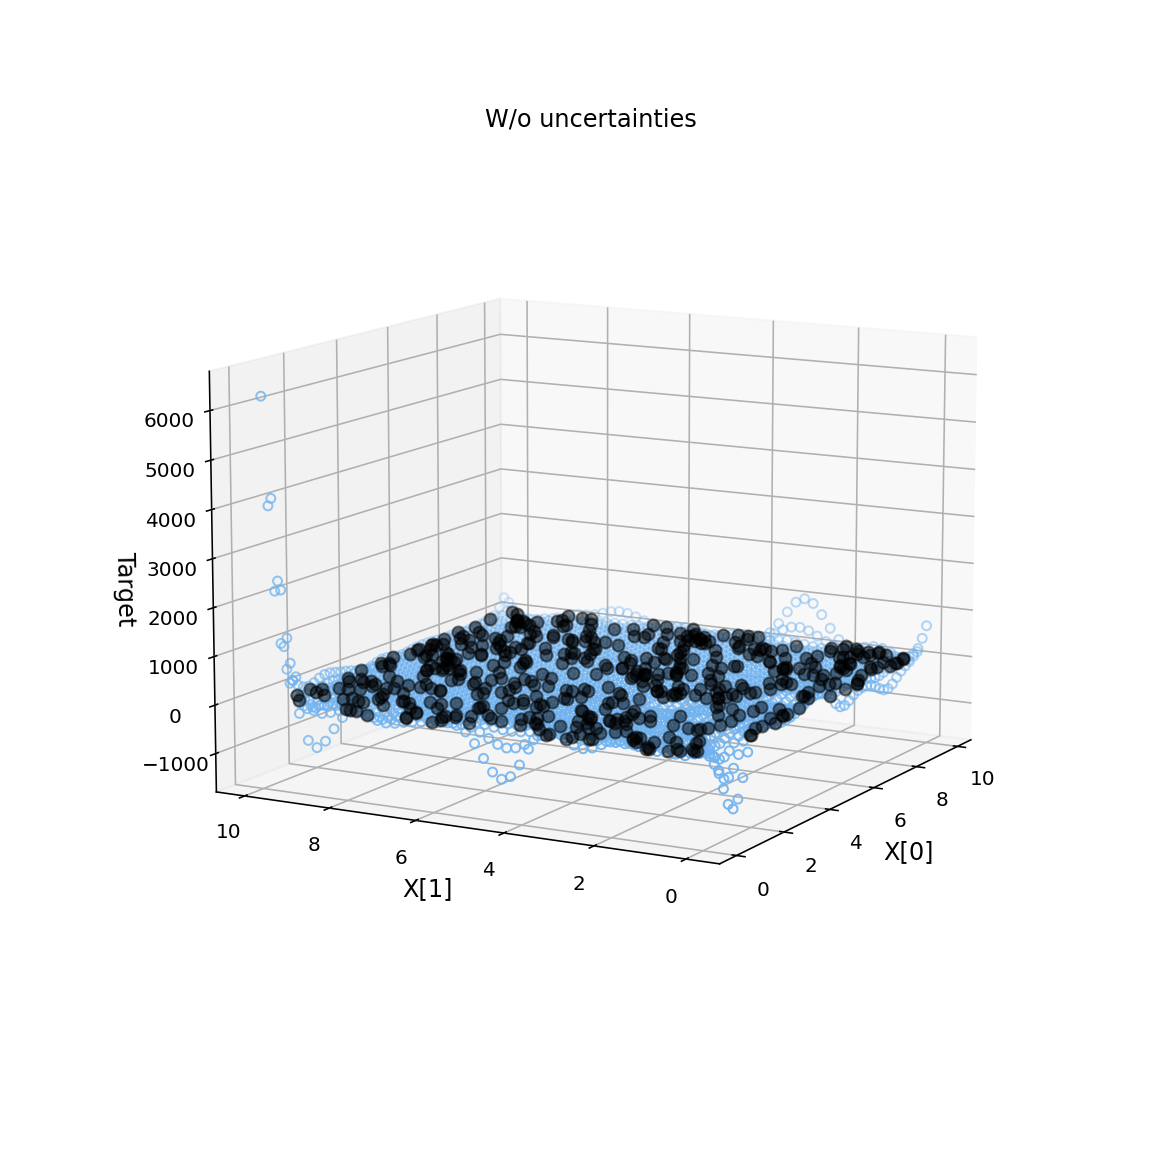

In [37]:
# plot w/o error
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0], X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0].flatten(), Xgrid[:,1].flatten(), y_pred_gp1, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.set_title('W/o uncertainties')

ax.view_init(elev=28, azim=120)

<IPython.core.display.Javascript object>


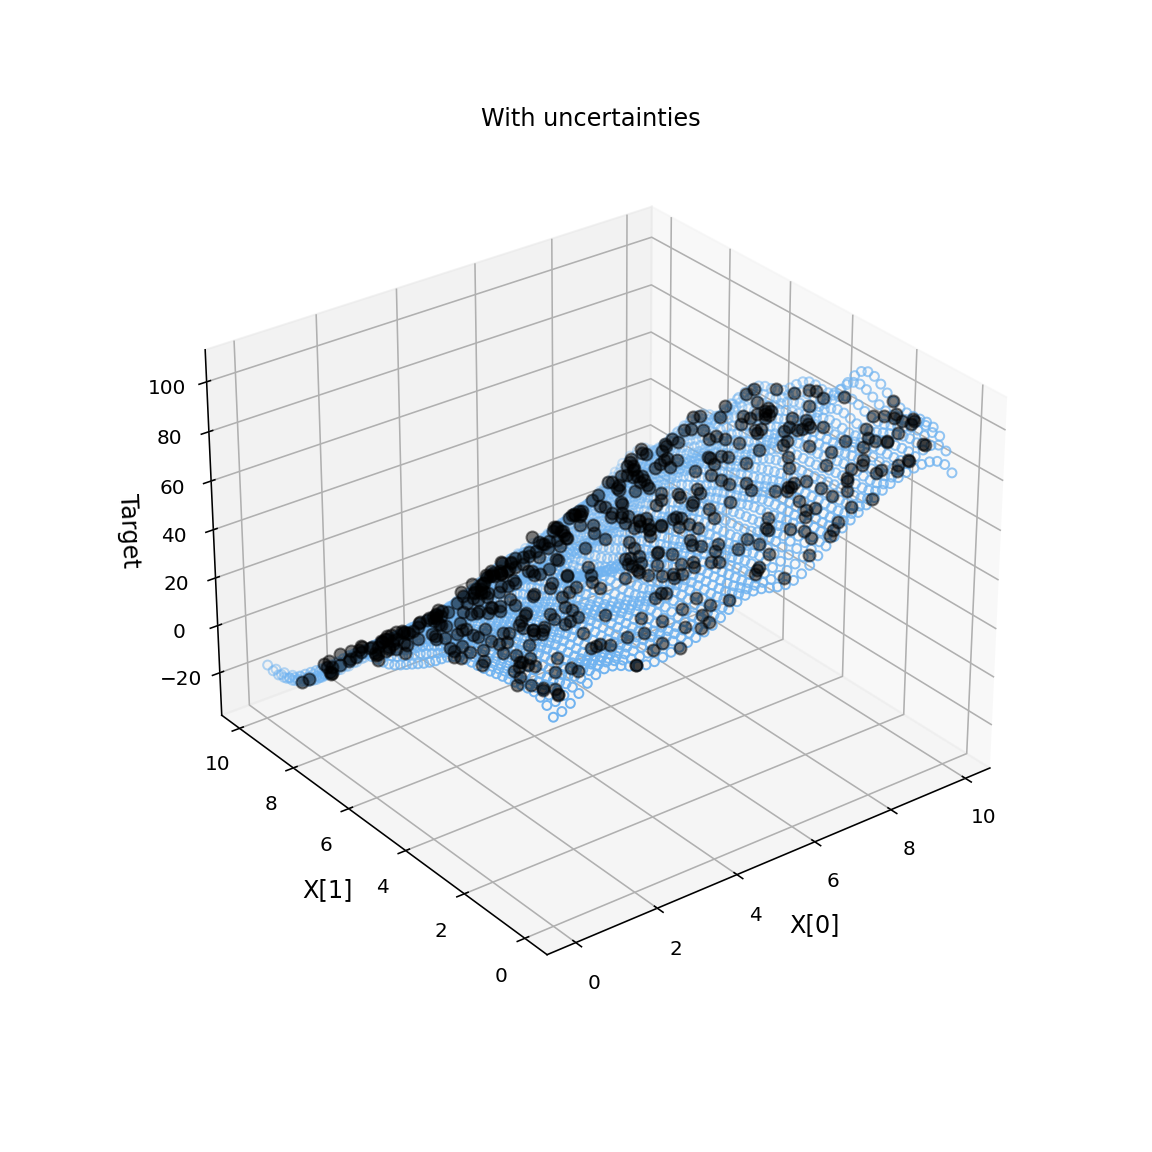

In [38]:
# plot w errors
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0], X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0].flatten(), Xgrid[:,1].flatten(), y_pred_gp2, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.set_title('With uncertainties')

ax.view_init(elev=28, azim=120)

In [39]:
# To turn off interactive plotting
%matplotlib inline

##### 7.

In [40]:
# plotting a 4th degree poly on the dataset
degree = 4
pr = PolynomialRegression(degree)
pr.fit(X, y, yerr)

y_pred_pr = pr.predict(Xgrid)

In [41]:
print('Regression coefficients for 4th degree polynomial:')
print(pr.coef_)

Regression coefficients for 4th degree polynomial:
[ 4.99887582e+01  5.54313398e-01 -2.07866484e-01  2.86536907e-01
  2.93842380e-03 -7.82230112e-01  2.47603263e-02  2.45748271e-02
 -2.22233559e-02  9.68417971e-03 -9.95958746e-04 -1.12284370e-03
 -1.14462222e-03  2.10142159e-03 -1.08539159e-03]


In [42]:
# playful poly plot
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:,0], X[:,1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(Xgrid[:,0].flatten(), Xgrid[:,1].flatten(), y_pred_pr, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

<IPython.core.display.Javascript object>

In [43]:
# To turn off interactive plotting
%matplotlib inline

The linear regression underplots the data, while GPR (with uncertainties) seemingly overplots the data as there are some perturbations on the predicted data points. This polynomial regression appeears to predict the dataset just right

##### 8.

In [31]:
# splitting the data in train, test and cv datasets
Xtrain, Xtest, ytrain, ytest, yerrtrain, yerrtest = train_test_split(X, y, yerr,
                                                                     test_size=0.2)
Xtrain2, Xcv, ytrain2, ycv, yerrtrain2, yerrcv = train_test_split(Xtrain, ytrain, yerrtrain,
                                                                  test_size=0.2)

In [32]:
# array of poly degrees
degree = np.arange(1,11)
no_d = len(degree)

# empty uncertainty arrays
train_err = np.zeros(no_d)
cv_err = np.zeros(no_d)

# loop over possible degrees
for ii in range(no_d):
    
    # perform regression
    pr = PolynomialRegression(degree[ii])
    pr.fit(Xtrain2, ytrain2, yerrtrain2)

    # calculate rms errors - weighted by errors
    ypred_train = pr.predict(Xtrain2)
    train_err[ii] = np.sqrt(np.sum(((ypred_train - ytrain2)/yerrtrain2) ** 2)
                              / len(ytrain2))
    
    ypred_cv = pr.predict(Xcv)
    cv_err[ii] = np.sqrt(np.sum(((ypred_cv - ycv)/yerrcv) ** 2)
                              / len(ycv))

# calculate BICs - scaling to full data size
BIC_train = np.sqrt(len(y)) * train_err + degree * np.log(len(y))
BIC_cv = np.sqrt(len(y)) * cv_err + degree * np.log(len(y))

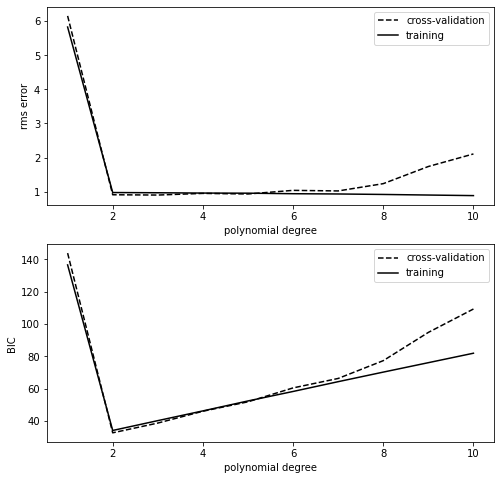

In [33]:
# plot errors and BICs
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(211)
ax.plot(degree, cv_err, '--k', label='cross-validation')
ax.plot(degree, train_err, '-k', label='training')

ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend()

ax = fig.add_subplot(212)
ax.plot(degree, BIC_cv, '--k', label='cross-validation')
ax.plot(degree, BIC_train, '-k', label='training')

ax.legend()
ax.set_xlabel('polynomial degree')
ax.set_ylabel('BIC')

plt.show()

In [34]:
# optimal degree is 2
d_opt = 2

pr = PolynomialRegression(degree=d_opt)
pr.fit(Xtrain, ytrain, yerrtrain)

ypred_opt = pr.predict(Xtest)

In [35]:
testerr = np.sqrt(np.sum((ypred_opt - ytest) ** 2)
                              / len(ytest))
print(f'Testing error = {testerr:.2f}')

Testing error = 1.92


Note: testing error highly dependent on randomness of train_test_split!